# SLEAP Proximity

### <b> This notebook is used to extract sleap-based features from a trial level (multiple mice) <b>

Features that will be extracted:
- head distance
- res head-int head angle
- res head-int hind distance
- res head-int hind angle
- int head-res hind distance
- int head-res hind angle
- hind distance
- resident velocity
- inrtuder velocity

Need to grab when a intruder is in and the identity of the intruder for downstream analysis

Extra Features to include:
- Brain region
- mouse identity
- standard zscored DA
- Intuder social identity

Convert h5 file data to only include times when another intruder is in

Convert frames to time to be able to line up DA values to times

Extract features from frames

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from bouts_extension import *
from slp_trl_class import SleapTrial

In [2]:
file = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_tdt\pp8-250121-142227"
csv_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_csvs\pp8-250121-142227.csv"
corner_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\corner_sleap\corners.v001.015_1_19_25_Home_Cage_C3-250118-111408_pp8-250121-142227_Cam1_converted.analysis.h5"

filename = r"C:\Users\alber\Downloads\da_round_2 final.015_1_19_25_Home_Cage_C3-250118-111408_pp8-250121-142227_Cam1_converted.analysis.h5"

video_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\HC_Videos_Only\1_19_25_Home_Cage_C3-250118-111408_pp8-250121-142227_Cam1_converted.mp4"

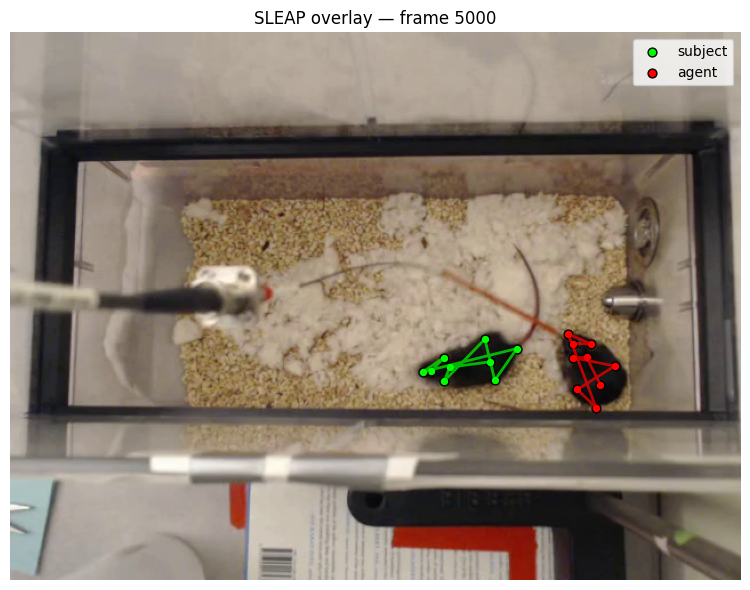

In [3]:
import h5py, cv2, numpy as np, matplotlib.pyplot as plt

def overlay_sleap_skeleton(h5_path, video_path, frame_i):
    # 1) Load & reshape
    with h5py.File(h5_path, "r") as f:
        raw = f["tracks"][:]              # shape = (inst, dims, nodes, frames)
        track_names = [t.decode() for t in f["track_names"][:]]
        node_names  = [n.decode() for n in f["node_names"][:]]
    # transpose to (frames, nodes, dims, instances)
    tracks = raw.transpose((3, 2, 1, 0))
    F, N, D, M = tracks.shape

    if not (0 <= frame_i < F):
        raise IndexError(f"frame_i ({frame_i}) must be in [0, {F})")

    # 2) grab the corresponding video frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
    ok, bgr = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read frame {frame_i}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # 3) overlay
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"SLEAP overlay — frame {frame_i}")

    colors = ["lime","red","cyan","magenta"]  # one per instance
    for m in range(M):
        pts = tracks[frame_i, :, :, m]   # (N_nodes, 2)
        # if your dims are (x,y):
        xs, ys = pts[:,0], pts[:,1]
        # if you find them flipped, swap to:
        # xs, ys = pts[:,1], pts[:,0]

        ax.scatter(xs, ys,
                   c=colors[m], s=40, edgecolor="k",
                   label=track_names[m])
        ax.plot(xs, ys, c=colors[m], lw=2, alpha=0.7)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()



overlay_sleap_skeleton(filename, video_path, frame_i=5000)


In [4]:
trial = SleapTrial(file, '_465A', '_405A')

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\all_tdt\pp8-250121-142227\Notes.txt
read from t=0s to t=1871.97s


In [5]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]
trial.extract_bouts_and_behaviors(csv_path, bout_definitions, first_only=False)
trial.combine_consecutive_behaviors(behavior_name='all', bout_time_threshold=1)

In [6]:
trial.downsample(target_fs = 100)

# 2.5) Remove beginning and end
trial.remove_initial_LED_artifact(t=30)
trial.remove_final_data_segment(t=10)

# 3) low‐pass
trial.lowpass_filter(cutoff_hz=3.0)

# 4) high‐pass recentered
trial.baseline_drift_highpass_recentered(cutoff=0.001)

# 5) IRLS fit
trial.motion_correction_align_channels_IRLS(IRLS_constant=1.4)

# 6) compute dF/F
trial.compute_dFF()

# 7) zscore
trial.compute_zscore(method='standard')

Sleap

In [7]:
# filename = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\sleap_id_corrected\da_round_2 final (2) copy.008_1_19_25_Home_Cage_C3-250118-111408_pp1-250120-094415_Cam1_converted.analysis.h5"
# filename = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\SLEAP\sleap_id_corrected\da_round_2 final (2) copy.008_1_19_25_Home_Cage_C3-250118-111408_pp1-250120-094415_Cam1_converted.analysis.h5"
trial.load_sleap(h5_path=filename, fps = 10)

trial.calibrate_from_corners(
    corner_h5_path=corner_path,
    real_width_cm=32,
    top_left="Top_Left",
    top_right="Top_Right"
)

trial.filter_sleap_bouts()
trial.smooth_locations()

DA

In [8]:
trial.add_metadata_and_DA()

time_s brain_region mouse_identity  zscore_DA intruder_identity
0       185.2         mPFC            pp8   0.279553      Short_Term-1
1       185.3         mPFC            pp8   0.171266      Short_Term-1
2       185.4         mPFC            pp8  -0.285045      Short_Term-1
3       185.5         mPFC            pp8   0.094867      Short_Term-1
4       185.6         mPFC            pp8   0.419848      Short_Term-1
...       ...          ...            ...        ...               ...
15107  1803.7         mPFC            pp8  -0.553901      Short_Term-2
15108  1803.8         mPFC            pp8   0.135497      Short_Term-2
15109  1803.9         mPFC            pp8   0.513378      Short_Term-2
15110  1804.0         mPFC            pp8   0.454459      Short_Term-2
15111  1804.1         mPFC            pp8   0.053515      Short_Term-2

[15112 rows x 5 columns]

In [22]:
trial.add_behavior_column(time_col="time_s",
                               out_col="behavior_active",
                               mode="all")

time_s brain_region mouse_identity  zscore_DA intruder_identity  \
0       185.2         mPFC            pp8   0.279553      Short_Term-1   
1       185.3         mPFC            pp8   0.171266      Short_Term-1   
2       185.4         mPFC            pp8  -0.285045      Short_Term-1   
3       185.5         mPFC            pp8   0.094867      Short_Term-1   
4       185.6         mPFC            pp8   0.419848      Short_Term-1   
...       ...          ...            ...        ...               ...   
15107  1803.7         mPFC            pp8  -0.553901      Short_Term-2   
15108  1803.8         mPFC            pp8   0.135497      Short_Term-2   
15109  1803.9         mPFC            pp8   0.513378      Short_Term-2   
15110  1804.0         mPFC            pp8   0.454459      Short_Term-2   
15111  1804.1         mPFC            pp8   0.053515      Short_Term-2   

      agent_in_subject subject_in_agent  distance_head_res__head_int  \
0                   No               No                    28.505707   
1                   No               No                    27.081035   
2                   No               No                    25.680297   
3                   No               No                    24.299306   
4                   No               No                    22.937845   
...                ...              ...                          ...   
15107               No               No                    11.583698   
15108               No               No                    12.274289   
15109               No               No                    13.197922   
15110               No               No                    14.381442   
15111               No               No                    15.850811   

       angle_head_res__head_int_deg  distance_head_res__hind_int  \
0                        176.766382                    30.006914   
1                        164.685051                    29.453562   
2                        146.167582                    28.809570   
3                        116.400616                    28.066655   
4                         83.304725                    27.223522   
...                             ...                          ...   
15107                      0.215972                    16.505186   
15108                     16.998314                    17.141729   
15109                     38.286007                    17.984381   
15110                     59.044973                    19.057355   
15111                     75.067711                    20.385360   

       angle_head_res__hind_int_deg  distance_head_int__hind_res  \
0                        170.689984                    31.072479   
1                        174.520051                    29.513748   
2                        158.998407                    28.012163   
3                        143.107543                    26.567329   
4                        127.628448                    25.181837   
...                             ...                          ...   
15107                      8.948863                     7.312807   
15108                      7.619227                     7.799026   
15109                     28.916657                     8.453466   
15110                     49.951128                     9.340239   
15111                     66.546034                    10.526785   

       angle_head_int__hind_res_deg  distance_hind_res__hind_int  \
0                        176.214068                    33.374908   
1                        173.977550                    32.625609   
2                        157.164280                    31.800490   
3                        128.592697                    30.896168   
4                         96.259645                    29.914296   
...                             ...                          ...   
15107                      6.002379                    11.990063   
15108                     19.200868                    12.553003   
15109  

In [27]:
trial.add_social_labels(a_cm =6, b_cm = 4)

c:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\slp_trl_class.py:492: RuntimeWarning: Mean of empty slice
  C = np.nanmean(loc[:, :, :, t_c], axis=1)   # shape (F,2)


time_s brain_region mouse_identity  zscore_DA intruder_identity  \
0       185.2         mPFC            pp8   0.279553      Short_Term-1   
1       185.3         mPFC            pp8   0.171266      Short_Term-1   
2       185.4         mPFC            pp8  -0.285045      Short_Term-1   
3       185.5         mPFC            pp8   0.094867      Short_Term-1   
4       185.6         mPFC            pp8   0.419848      Short_Term-1   
...       ...          ...            ...        ...               ...   
15107  1803.7         mPFC            pp8  -0.553901      Short_Term-2   
15108  1803.8         mPFC            pp8   0.135497      Short_Term-2   
15109  1803.9         mPFC            pp8   0.513378      Short_Term-2   
15110  1804.0         mPFC            pp8   0.454459      Short_Term-2   
15111  1804.1         mPFC            pp8   0.053515      Short_Term-2   

      agent_in_subject subject_in_agent  distance_head_res__head_int  \
0                   No               No                    28.505707   
1                   No               No                    27.081035   
2                   No               No                    25.680297   
3                   No               No                    24.299306   
4                   No               No                    22.937845   
...                ...              ...                          ...   
15107               No               No                    11.583698   
15108               No               No                    12.274289   
15109               No               No                    13.197922   
15110               No               No                    14.381442   
15111               No               No                    15.850811   

       angle_head_res__head_int_deg  distance_head_res__hind_int  \
0                        176.766382                    30.006914   
1                        164.685051                    29.453562   
2                        146.167582                    28.809570   
3                        116.400616                    28.066655   
4                         83.304725                    27.223522   
...                             ...                          ...   
15107                      0.215972                    16.505186   
15108                     16.998314                    17.141729   
15109                     38.286007                    17.984381   
15110                     59.044973                    19.057355   
15111                     75.067711                    20.385360   

       angle_head_res__hind_int_deg  distance_head_int__hind_res  \
0                        170.689984                    31.072479   
1                        174.520051                    29.513748   
2                        158.998407                    28.012163   
3                        143.107543                    26.567329   
4                        127.628448                    25.181837   
...                             ...                          ...   
15107                      8.948863                     7.312807   
15108                      7.619227                     7.799026   
15109                     28.916657                     8.453466   
15110                     49.951128                     9.340239   
15111                     66.546034                    10.526785   

       angle_head_int__hind_res_deg  distance_hind_res__hind_int  \
0                        176.214068                    33.374908   
1                        173.977550                    32.625609   
2                        157.164280                    31.800490   
3                        128.592697                    30.896168   
4                         96.259645                    29.914296   
...                             ...                          ...   
15107                      6.002379                    11.990063   
15108                     19.200868                    12.553003   
15109  

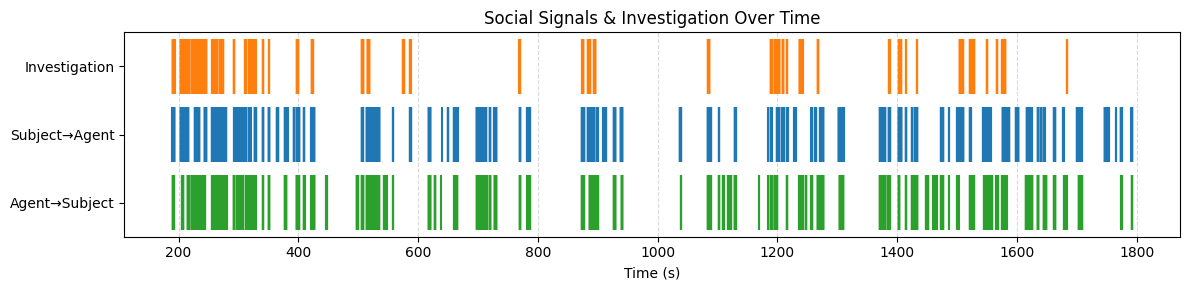

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 1) pull out your time‐series and boolean masks
df = trial.features_df
times = df["time_s"].to_numpy()

mask_subj2agent = (df["subject_in_agent"] == "Yes").to_numpy()
mask_agent2subj = (df["agent_in_subject"] == "Yes").to_numpy()
mask_invest     = (df["behavior_active"] == "Investigation").to_numpy()

# 2) get the raw times at which each is True
t_subj2agent = times[mask_subj2agent]
t_agent2subj = times[mask_agent2subj]
t_invest     = times[mask_invest]

# 3) make a single axis with three event‐lines
fig, ax = plt.subplots(figsize=(12, 3))

ax.eventplot(
    [t_agent2subj, t_subj2agent, t_invest],
    colors=["tab:green", "tab:blue", "tab:orange"],
    lineoffsets=[1, 2, 3],
    linelengths=0.8,
)

# 4) prettify
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(["Agent→Subject", "Subject→Agent", "Investigation"])
ax.set_xlabel("Time (s)")
ax.set_title("Social Signals & Investigation Over Time")
ax.grid(axis="x", color="gray", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


In [24]:
df = trial.features_df
agent_yes   = (df["agent_in_subject"]   == "Yes").sum()
subject_yes = (df["subject_in_agent"]   == "Yes").sum()

print(f"Frames where agent→subject = Yes:   {agent_yes}")
print(f"Frames where subject→agent = Yes:   {subject_yes}")


Frames where agent→subject = Yes:   2699
Frames where subject→agent = Yes:   2657


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_skeleton(trial, frame_i: int, video_path: str):
    """
    Overlay the **true full-frame** SLEAP tracks from trial._raw_locations
    onto video frame #frame_i.  (No cropping, no ROI offsets.)
    """
    # 1) make sure video is open
    if not hasattr(trial, "_video") or trial._video is None:
        trial.load_video(video_path)

    # 2) get the SLEAP coords at that frame
    #    _raw_locations is (frames, nodes, 2, instances)
    tracks = trial._raw_locations
    F, N, D, M = tracks.shape
    if not (0 <= frame_i < F):
        raise IndexError(f"frame_i must be 0..{F-1}")
    pts_frame = tracks[frame_i]  # (nodes, 2, instances)

    # 3) grab the exact video frame
    trial._video.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
    ok, bgr = trial._video.read()
    if not ok:
        raise IOError(f"cannot read frame {frame_i}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # 4) plot
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Raw SLEAP — frame {frame_i}")

    colors = ["lime","red"]  # up to two mice
    for inst in range(M):
        xy = pts_frame[:,:,inst]   # (nodes,2)
        xs, ys = xy[:,0], xy[:,1]  # already full-frame coords
        ax.scatter(xs, ys, c=colors[inst], s=40, edgecolor="k")
        ax.plot(xs, ys, c=colors[inst], lw=2, alpha=0.7,
                label=list(trial.track_dict.keys())[inst])

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_raw_frame_skeleton(trial, frame_i: int, video_path: str = None):
    """
    Plot video‐frame #frame_i with the *raw* (uncropped, unsmoothed) SLEAP skeleton
    for both 'subject' and 'agent'.  If *any* node at that frame is NaN, raises.
    
    Parameters
    ----------
    trial : SleapTrial
      Your trial, *after* load_sleap(...). Expects trial._raw_locations to be
      shape (frames, nodes, dims, instances).
    frame_i : int
      The *raw* video frame to grab (0..n_frames-1).
    video_path : str, optional
      If trial._video isn’t yet open, will load this path.
    """
    # 1) make sure frame_i is in range
    raw = trial._raw_locations
    F = raw.shape[0]
    if not (0 <= frame_i < F):
        raise IndexError(f"Requested frame {frame_i} out of range [0, {F})")
    
    # 2) check for any NaNs
    this_frame = raw[frame_i]  # shape = (nodes, dims, instances)
    if np.isnan(this_frame).any():
        raise ValueError(f"SLEAP has missing data (NaN) in frame {frame_i}; aborting.")
    
    # 3) load video if needed
    if not hasattr(trial, "_video") or trial._video is None:
        if video_path is None:
            raise ValueError("No video loaded—pass video_path")
        trial.load_video(video_path)
    
    # 4) grab the exact same video frame
    trial._video.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
    ok, bgr = trial._video.read()
    if not ok:
        raise RuntimeError(f"Could not read video frame {frame_i}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    # 5) plot background + skeleton
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Raw SLEAP skeleton — frame {frame_i}")
    
    colors = {"subject":"lime", "agent":"red"}
    for track_name, t_idx in trial.track_dict.items():
        if track_name not in colors:
            continue
        pts = this_frame[:, :, t_idx]  # (nodes, dims)
        xs, ys = pts[:,0], pts[:,1]    # x = col, y = row
        ax.scatter(xs, ys, c=colors[track_name], s=50, edgecolor="k", label=track_name)
        ax.plot(xs, ys, c=colors[track_name], lw=2, alpha=0.7)
    
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()



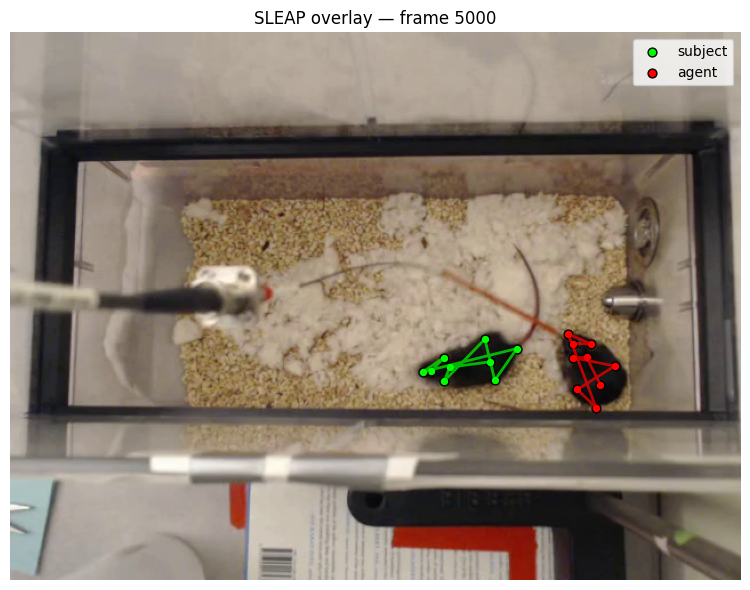

In [12]:
import h5py, cv2, numpy as np, matplotlib.pyplot as plt

def overlay_sleap_skeleton(h5_path, video_path, frame_i):
    # 1) Load & reshape
    with h5py.File(h5_path, "r") as f:
        raw = f["tracks"][:]              # shape = (inst, dims, nodes, frames)
        track_names = [t.decode() for t in f["track_names"][:]]
        node_names  = [n.decode() for n in f["node_names"][:]]
    # transpose to (frames, nodes, dims, instances)
    tracks = raw.transpose((3, 2, 1, 0))
    F, N, D, M = tracks.shape

    if not (0 <= frame_i < F):
        raise IndexError(f"frame_i ({frame_i}) must be in [0, {F})")

    # 2) grab the corresponding video frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
    ok, bgr = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Could not read frame {frame_i}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # 3) overlay
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"SLEAP overlay — frame {frame_i}")

    colors = ["lime","red","cyan","magenta"]  # one per instance
    for m in range(M):
        pts = tracks[frame_i, :, :, m]   # (N_nodes, 2)
        # if your dims are (x,y):
        xs, ys = pts[:,0], pts[:,1]
        # if you find them flipped, swap to:
        # xs, ys = pts[:,1], pts[:,0]

        ax.scatter(xs, ys,
                   c=colors[m], s=40, edgecolor="k",
                   label=track_names[m])
        ax.plot(xs, ys, c=colors[m], lw=2, alpha=0.7)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()



overlay_sleap_skeleton(filename, video_path, frame_i=5000)


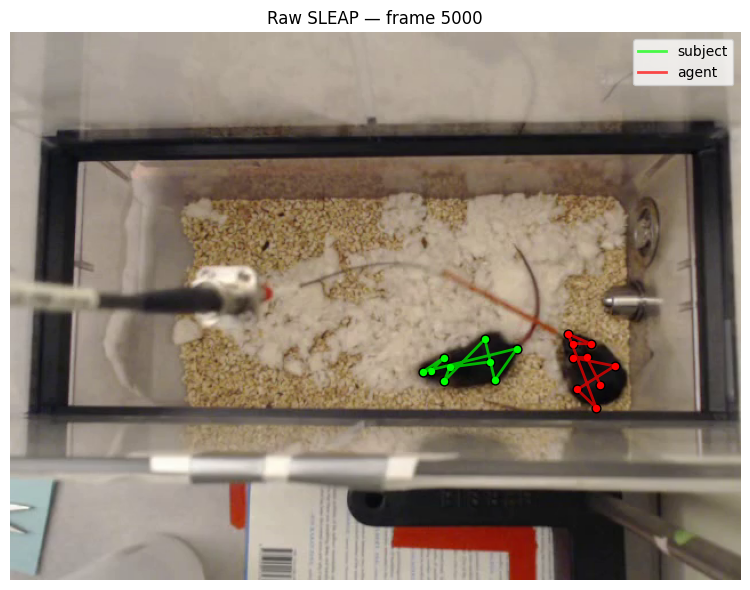

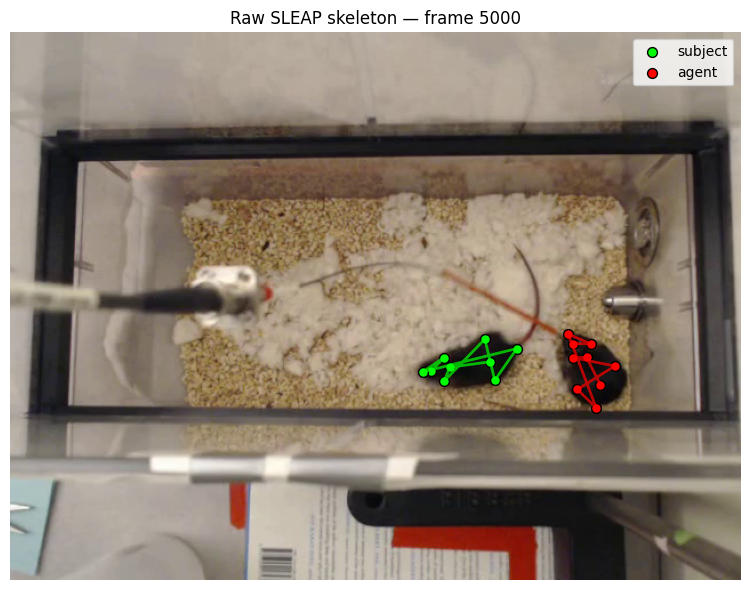

In [13]:
plot_raw_skeleton(trial, 5000, video_path)
plot_raw_frame_skeleton(trial, 5000, video_path)


c:\Users\alber\OneDrive\Documents\GitHub\Fiber_Photometry\Pose_Tracking\slp_trl_class.py:492: RuntimeWarning: Mean of empty slice
  C = np.nanmean(loc[:, :, :, t_c], axis=1)   # shape (F,2)


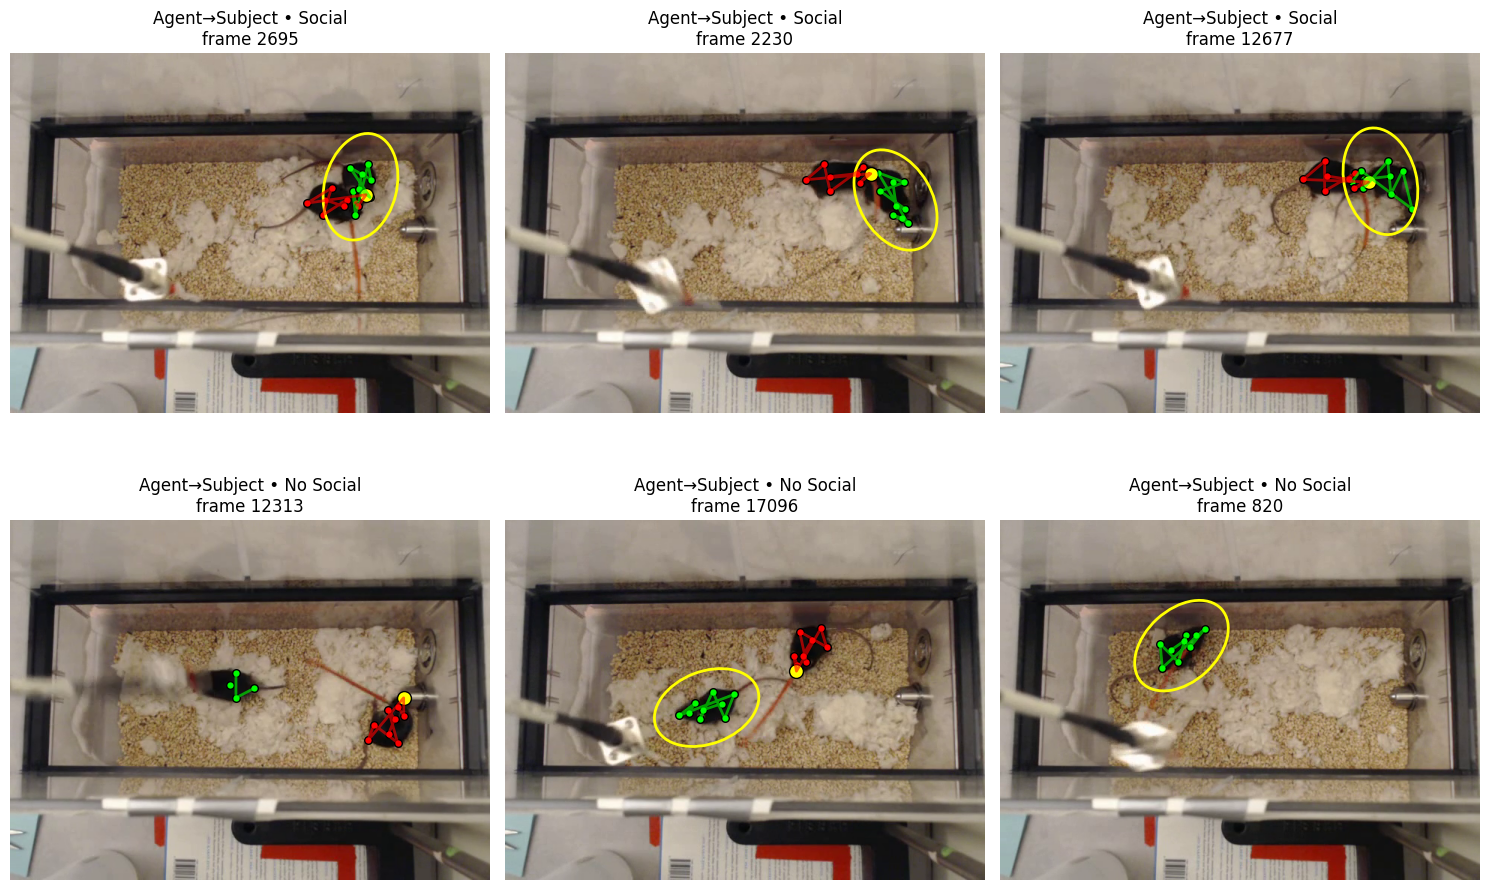

C:\Users\alber\AppData\Local\Temp\ipykernel_18116\4010155567.py:73: RuntimeWarning: Mean of empty slice
  C    = np.nanmean(LOCS, axis=0)      # (2,)


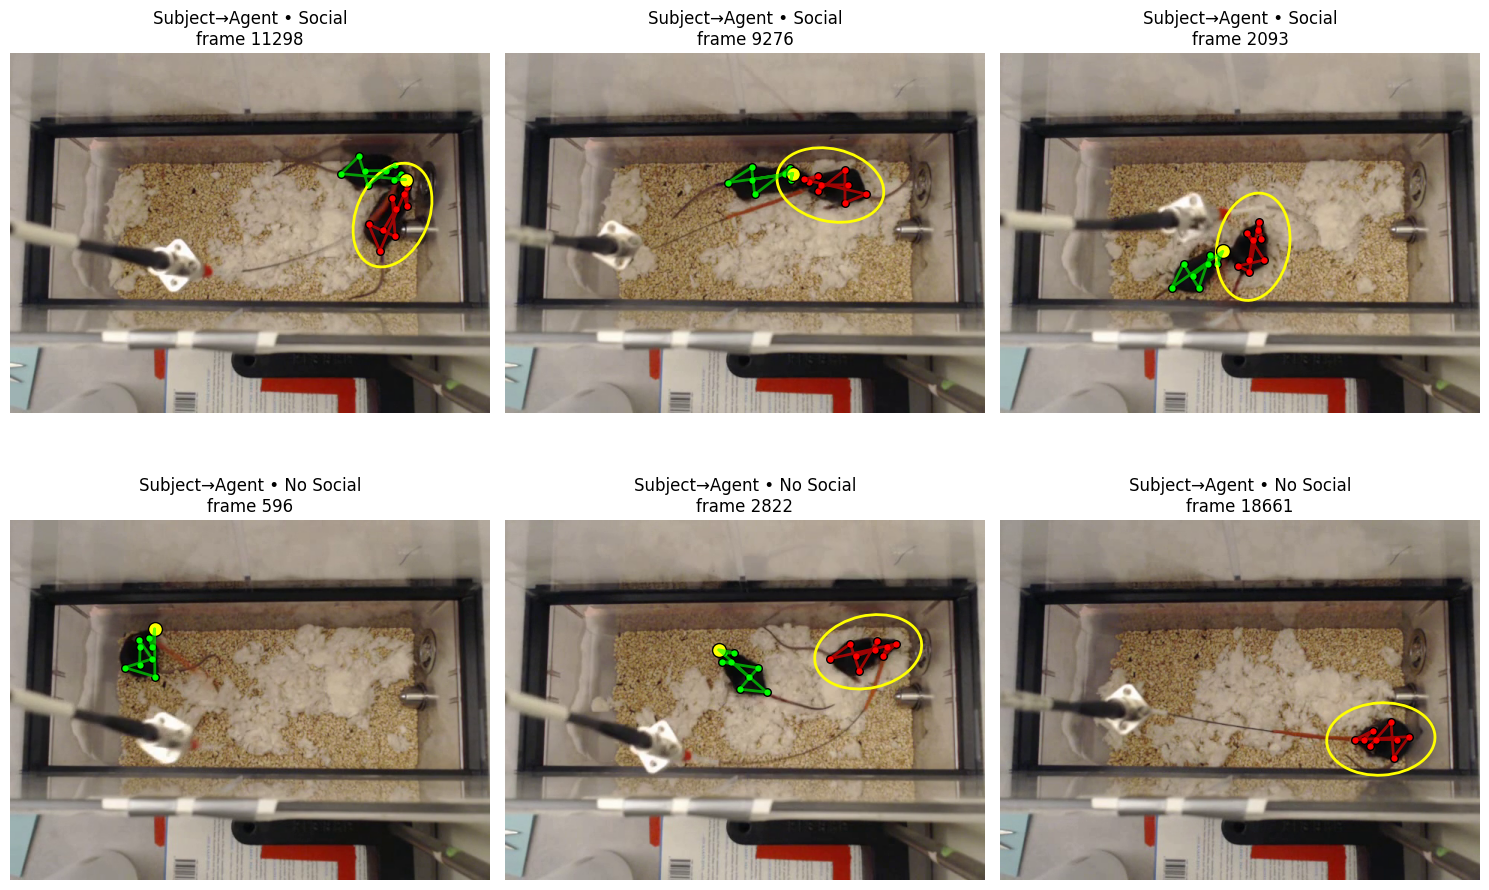

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Ellipse

# ── USER SETTINGS ───────────────────────────────────────────────────────────────
VIDEO_PATH   = video_path
a_cm, b_cm   = 6, 4        # ellipse semi-axes in cm
N_SAMPLES    = 3               # how many per category
angle_src    = "Tail_Base"     # ellipse orientation vector start
angle_dst    = "Nose"          # ellipse orientation vector end

# ── 1) open video ───────────────────────────────────────────────────────────────
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError("Could not open video!")

# ── 2) precompute px-axes ────────────────────────────────────────────────────────
if trial.px_to_cm is None:
    raise RuntimeError("Call trial.calibrate_from_corners(...) first")
a_px = a_cm / trial.px_to_cm
b_px = b_cm / trial.px_to_cm

# ── 3) get both masks over the FULL raw frame-count ───────────────────────────────
mask_agent, mask_subject = trial.compute_social_ellipse_masks(a_cm, b_cm)

def _plot_grid(mask, label, center_track, target_track):
    """
    mask        : boolean array length = n_raw_frames
    label       : str, for titles ("Agent→Subject" or "Subject→Agent")
    center_track: whose ellipse we draw ("subject" or "agent")
    target_track: whose nose we scatter ("agent" or "subject")
    """
    F = trial._raw_locations.shape[0]
    all_idxs = np.arange(F)
    pos_idxs = all_idxs[mask]
    neg_idxs = all_idxs[~mask]

    # sample raw frame-indices
    pos_samp = random.sample(pos_idxs.tolist(), min(N_SAMPLES, len(pos_idxs)))
    neg_samp = random.sample(neg_idxs.tolist(), min(N_SAMPLES, len(neg_idxs)))

    fig, axs = plt.subplots(2, N_SAMPLES, figsize=(5*N_SAMPLES, 10))
    for row, (samps, title) in enumerate([(pos_samp, "Social"), (neg_samp, "No Social")]):
        for col, frame_i in enumerate(samps):
            ax = axs[row, col]
            # ── fetch & show video frame ─────────────────────────
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
            ret, bgr = cap.read()
            if not ret:
                ax.set_title(f"Missing {frame_i}")
                ax.axis("off")
                continue
            img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"{label} • {title}\nframe {frame_i}")

            # ── 1) draw the raw SLEAP skeleton ──────────────────
            raw = trial._raw_locations  # (frames, nodes, dims, instances)
            for tn, colr in [("subject","lime"), ("agent","red")]:
                t_i = trial.track_dict[tn]
                pts = raw[frame_i, :, :, t_i]    # (N_nodes, 2)
                xs, ys = pts[:,0], pts[:,1]
                ax.scatter(xs, ys, s=30, c=colr, edgecolor="k")
                ax.plot(xs, ys, c=colr, linewidth=2, alpha=0.6)

            # ── 2) compute & draw the ellipse at the body-centroid ─────
            c_idx = trial.track_dict[center_track]
            # mean across all nodes = point‐wise "center of mass"
            LOCS = raw[frame_i, :, :, c_idx]     # (N_nodes, 2)
            C    = np.nanmean(LOCS, axis=0)      # (2,)

            # orientation vector
            dst = trial.node_dict[angle_dst]
            src = trial.node_dict[angle_src]
            V   = ( raw[frame_i, dst, :, c_idx]
                  - raw[frame_i, src, :, c_idx] )
            theta = np.degrees(np.arctan2(V[1], V[0]))

            ell = Ellipse(xy=C,
                          width = 2*a_px,
                          height= 2*b_px,
                          angle=  theta,
                          edgecolor="yellow",
                          fill=False,
                          lw=2)
            ax.add_patch(ell)

            # ── 3) highlight the target nose ────────────────────
            pn_idx = trial.track_dict[target_track]
            Pn    = raw[frame_i, trial.node_dict["Nose"], :, pn_idx]
            ax.scatter(Pn[0], Pn[1], c="yellow", s=100, edgecolor="k")

    plt.tight_layout()
    plt.show()

# ── 4) plot agent→subject sociality ─────────────────────────────────────────────
_plot_grid(mask_agent,
           label="Agent→Subject",
           center_track="subject",
           target_track="agent")

# ── 5) plot subject→agent sociality ─────────────────────────────────────────────
_plot_grid(mask_subject,
           label="Subject→Agent",
           center_track="agent",
           target_track="subject")

cap.release()


In [20]:
df = trial.compute_pairwise_features()